In [1]:
import pandas as pd
import numpy as np

from scipy.interpolate import griddata

from matplotlib.widgets import Slider
import matplotlib.pyplot as plt

import plotly.graph_objects as go

from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from classification_tools import manualMLPClassifier, NN_train_visualize, draw_neural_net

%matplotlib widget
# %matplotlib nbagg

# Fix a seed
np.random.seed(1)

![overview beam structure](img/beam_structure.png)

## Introduction
In this notebook, you should apply the techniques you learned for classification in a more realistic problem setting. In the previous regression application, we predicted the position of a defect in the beam based on manually selected sensors. Here, we will try to classify the structural health of the beam. We are taking the extreme case of either requiring no maintenance or being so damaged that the beam needs to be demolished.

First, we will use the data from two hand-picked sensors. After trying to get the best accuracy in this way, we will use turn to use all sensors simultaneously using dimensionality reduction. By carefully constructing the network, we can visualize what happens inside the network you trained. With that understanding, you will be tasked to find the best number of features to get the overall best prediction score.

Let us start by taking a look at our data.

In [2]:
# Load the dataset that contains the (inherently noisy) observations
df = pd.read_csv('classification-data_realistic.csv')
df.head()

sample  node     x    y        dy intervention
0       0     0   0.0  0.0  0.000244  unnecessary
1       0     1  10.0  0.0 -0.000092  unnecessary
2       0     2  10.0  2.0 -0.005379  unnecessary
3       0     3   5.0  2.0 -0.045660  unnecessary
4       0     4   0.0  2.0 -0.004839  unnecessary

The intervention, our target, is currently a string of either [unnecessary] or [demolition]. Using these classes with our computational tools requires converting them to a numerical value. In this 2-class problem we choose 0 & 1 respectively.

In [3]:
# Format all the data
nodes_per_beam = df[df['sample'] == 0].shape[0]

x = df[['dy']].to_numpy().flatten()
X = np.reshape(x, (-1, nodes_per_beam))  # Shape: [Num_samples x num_features]

# Replace the strings of our targets with numerical labels
mapping = {'unnecessary' : 0, 'demolition' : 1}
df_numeric = df.replace({'intervention' : mapping})     # Replace strings with integers
damage_classes = df_numeric.iloc[::nodes_per_beam]['intervention']
df_numeric.head()

sample  node     x    y        dy  intervention
0       0     0   0.0  0.0  0.000244             0
1       0     1  10.0  0.0 -0.000092             0
2       0     2  10.0  2.0 -0.005379             0
3       0     3   5.0  2.0 -0.045660             0
4       0     4   0.0  2.0 -0.004839             0

## Data visualization and feature extraction
Let's take a look at the beam again and all the locations for which we have data.

In [4]:
bar_0 = df[df['sample'] == 50]
grid_x, grid_y = np.mgrid[0.02:9.98:250j, 0.02:1.98:50j]
grid_z = griddata(bar_0[['x','y']].to_numpy(), bar_0['dy'], (grid_x, grid_y))

# plot displacement-field and nodes
fig = go.Figure()
fig.add_trace(go.Heatmap(z=grid_z.transpose(),
                         x=grid_x[:,0],
                         y=grid_y[0],
                         hoverinfo='skip',
                         name='heatmap'))

# plot nodes
fig.add_trace(go.Scatter(x=bar_0['x'],
                         y=bar_0['y'],
                         mode='markers',
                         marker_color='black',
                         name='',
                         hovertemplate='<b>Node</b>: %{text}',
                         text=bar_0['node']))

# add buttons to display different displacement fields
fig.update_layout(
    updatemenus=[
        dict(
            buttons=list([
                dict(
                    args=['z', [griddata(bar_0[['x','y']].to_numpy(), bar_0['dy'], (grid_x, grid_y)).transpose()]],
                    label='y',
                    method='restyle')
            ]),
            direction='right', pad={'r': 10, 't': 10}, showactive=True, x=0.5, xanchor='left', y=1.1,
            yanchor='bottom', type='buttons', font=dict(size=13)
        ),
    ]
)

# Add annotation for button
fig.add_annotation(dict(font=dict(size=13), x=0.5, y=1.13, showarrow=False,
                   xref='paper', yref='paper', xanchor='right', yanchor='bottom', text='Displacement: '))

# update xaxis range and show figure
fig.update_xaxes(range=(-0.2,10.2), constrain='domain')
fig.show()

You can pick two sensors that measure the y displacement, which is used as the input to the classification model. You can find the number of the sensor by hovering over the above plot. The following section shows which sensors you picked.

In [5]:
# define measurement locations, get corresponding coord
# ----------------------------------------
# measure_locs = [17, 73] # <- fill in the indices of the 2 sensors you select
measure_locs = [29, 2] # <- fill in the indices of the 2 sensors you select
# ----------------------------------------

measure_coords = np.array([bar_0[bar_0['node'] == loc][['x','y']].to_numpy() for loc in measure_locs]).squeeze(1)

measurements = X[:,measure_locs]

bar = df[df['sample'] == 1]
# measure_coords = np.array([bar[bar['node'] == loc][['x','y']].to_numpy() for loc in measure_locs]) #.squeeze(1)
grid_x, grid_y = np.mgrid[0.02:9.98:250j, 0.02:1.98:50j]

fig = go.Figure()
# plot measurement locations
fig.add_trace(go.Scatter(x=bar_0['x'],
                         y=bar_0['y'],
                         mode='markers',
                         marker_size=4,
                         marker_color='gray',
                         name='',
                         hovertemplate='<b>Node</b>: %{text}',
                         text=bar_0['node']))


fig.add_trace(go.Scatter(x = measure_coords[:,0], y = measure_coords[:,1], mode='markers',
                         marker=dict(size=15, color='DarkSlateGrey', line=dict(width=2, color='white')),
                         hovertemplate='<b>Node</b>: %{text}', text=measure_locs, name=''))
fig.update_layout(showlegend=False)
fig.update_xaxes(range=(-0.2,10.2), constrain='domain')
fig.show()


The two sensors record the y-displacement, here we can see how our data is distributed.

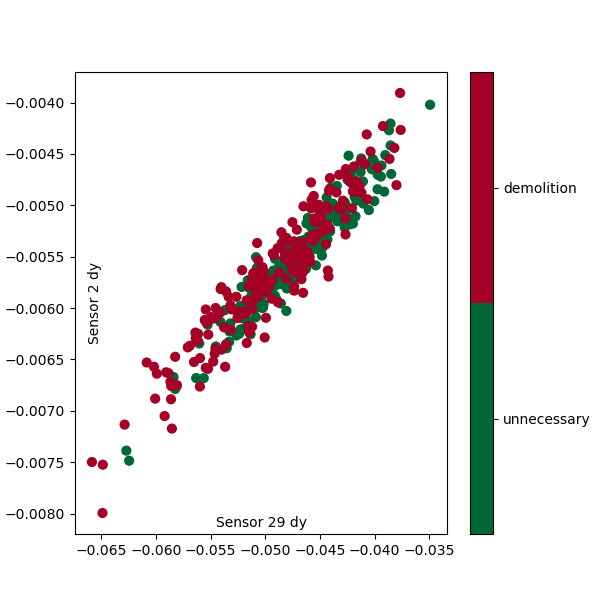

In [6]:
# fig, ax = plt.subplots(2,2,figsize=(10,10))
fig, ax = plt.subplots(figsize=(6,6))
cmap = plt.get_cmap('RdYlGn_r', 2)

plot1 = ax.scatter(measurements[:,0], measurements[:,1], c=damage_classes, cmap=cmap, vmin=-0.5, vmax=1.5, s=40)
ax.set_xlabel(f'Sensor {measure_locs[0]} dy', labelpad=-30)
ax.set_ylabel(f'Sensor {measure_locs[1]} dy', labelpad=-70)

cax = plt.colorbar(plot1, ticks=list(mapping.values()))
cax.ax.set_yticklabels(mapping.keys())
plt.show()

In the above 2D plots, there is a large correlation between our inputs, and it is unclear to which extent we can train any model to separate these. Lets try to do it anyway! First we will normalize our data and split it into a training, validation and test set.

In [7]:
# Properties required for classification
indices = np.arange(measurements.shape[0])
unique_classes = [0, 1]

# Normalize
xscaler = StandardScaler()
# xit = xscaler.inverse_transform
measurements_normalized = xscaler.fit_transform(measurements)

# Split into train, validation & test data: 70% 15% 15%
X_train, X_test, y_train, y_test, ind_train, ind_test = train_test_split(measurements_normalized, damage_classes, indices, train_size=0.7)
X_val, X_test, y_val, y_test, ind_val, ind_test = train_test_split(X_test, y_test, ind_test, train_size=0.5)

The data is now ready, it is time to implement a neural network. **Excercise 1:** Use what you have learned in the notebook, and think about ways to identify as well as alleviate overfitting. You can adapt the template below and use the same techniques you applied in the regression application.

In [8]:
# function to train the NN and obtain train & validation scores during training
def NN_train(NN, X_train, y_train, X_val, y_val, epochs=1000, verbose=True, lr_init=1e-3):
    validation_score = np.empty(epochs)
    training_score = np.empty(epochs)

    # set learning rate
    NN.learning_rate_init = lr_init

    # loop over iterations
    for epoch in range(epochs):

        # train for one epoch, compute the scores
        NN.partial_fit(X_train, y_train, classes=unique_classes)

        training_score[epoch] = NN.score(X_train, y_train)
        validation_score[epoch] = NN.score(X_val, y_val)

        # ----------------
        # Model selection code
        # ----------------

        # print loss (optional)
        if verbose and epoch%200==0:
            print(f"Iteration {epoch} out of {epochs}")

    # return trained network and last rmse
    return NN, training_score, validation_score

In [9]:
NN = MLPClassifier(solver='adam', hidden_layer_sizes=(20, 20), activation='relu', random_state=1)
# Optional: show we can use "alpha=.." in the line above to add regularization
NN, training_score, validation_score = NN_train(NN, X_train, y_train, X_val, y_val, epochs=2000)

# Plot your score
print(f"Train accuracy: {NN.score(X_train, y_train)}")
print(f"Validation accuracy: {NN.score(X_val, y_val)}")
print(f"Test accuracy: {NN.score(X_test, y_test)}")

Iteration 0 out of 2000
Iteration 200 out of 2000
Iteration 400 out of 2000
Iteration 600 out of 2000
Iteration 800 out of 2000
Iteration 1000 out of 2000
Iteration 1200 out of 2000
Iteration 1400 out of 2000
Iteration 1600 out of 2000
Iteration 1800 out of 2000
Train accuracy: 0.6821428571428572
Validation accuracy: 0.6333333333333333
Test accuracy: 0.5666666666666667


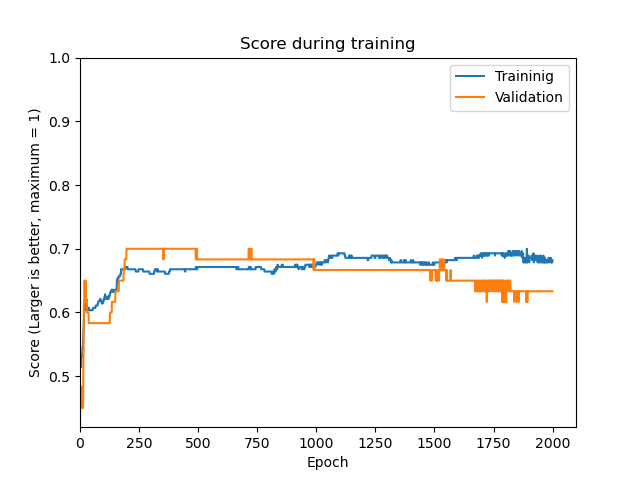

In [10]:
fig, ax = plt.subplots()
# plt.plot(NN.loss_curve_, label='training loss')
plt.plot(training_score, label='Traininig')
plt.plot(validation_score, label='Validation')
plt.title('Score during training')
plt.xlim(xmin=0)
plt.ylim(ymax=1)
plt.xlabel('Epoch')
plt.ylabel('Score (Larger is better, maximum = 1)')
plt.legend()
plt.show()

How did the network do? Note that randomly picking classes would give an accuracy of 0.5, which we can use as a baseline score. If we have everything correct, the score would be 1. Lets visualize the predictions in 2D. In the plot below, circles are plotted, where the center of each circle corresponds to the true label, and the border corresponds to the predicted label. Thus if both are the same the network has predicted correctly. The background provides a contour of the networks predictions.

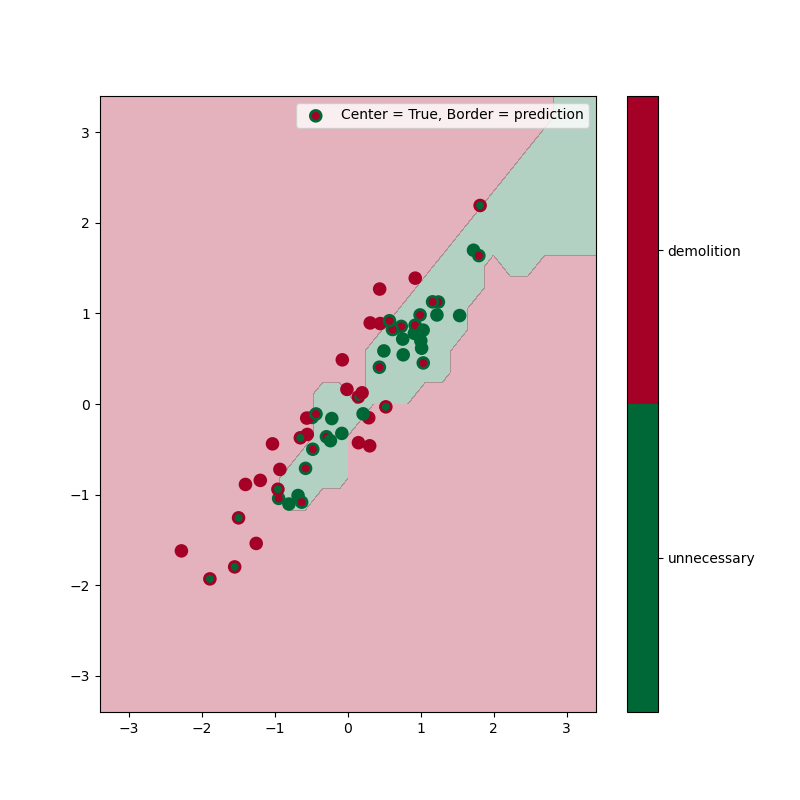

In [11]:
# Make predictions based on the test set
pred = NN.predict(X_test)

# Make predictions for the decision boundary
dx_points = 30
x = np.linspace(-3.4, 3.4, dx_points)
y = np.linspace(-3.4, 3.4, dx_points)
xv, yv = np.meshgrid(x, y, indexing='xy')
grid_points = np.append(xv.reshape(-1, 1), yv.reshape(-1, 1), axis=1)

pred_grid = NN.predict(grid_points)

# Plot
fig, ax = plt.subplots(figsize=(8,8))
prediction_color = cmap(pred/2)
ax.contourf(xv, yv, pred_grid.reshape(xv.shape), [0, 0.5, 1], cmap=cmap, alpha=0.3)
plot1 = ax.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap=cmap, edgecolors=prediction_color, vmin=-0.5, vmax=1.5, s=60, linewidth=2, label='Center = True, Border = prediction')
ax.legend()

cax = plt.colorbar(plot1, ticks=list(mapping.values()))
cax.ax.set_yticklabels(mapping.keys())
plt.show()

# Feature selection: Beyond 2 sensors
Based on the plot above, it is clear that using the inputs of two sensors to predict the output is very challenging. To see if we can get a better performance, lets now use the data from all sensors. As this would give us a large number of inputs, our network would also become significantly larger. A neural network in the way we use it here is not capable of efficiently learning the large number of required parameters, and more data would be required than is available. To enable us to use all information available from the sensors we turn to dimensionality reduction, and specifically Principal Component Analysis (PCA). To shortly recap, PCA fits a number of straight lines (principal components, or modes) through all data, and these modes can then be combined to try to reconstruct the full space as close as possible. Each mode is determined by explaining as much variance as possible.

### Dimensionality reduction and visualizing the inner working of a classification model
Before letting you try to improve your classification score, lets take a step back and try to understand what is happening inside our model. We will do this visually, which is possible by only selecting two modes using PCA.

In [12]:
# -------------------
num_modes = 2 # Keep this at 2 for now
# -------------------
pca = PCA(n_components=num_modes)
pca.fit(X)
print( f"The variance explained by each component = {pca.explained_variance_ratio_}")
print( f"The singular values = {pca.singular_values_}")
X_reduced = pca.transform(X)

The variance explained by each component = [9.97778486e-01 4.62766282e-04]
The singular values = [2.03912554 0.04391448]


Lets plot all our data in our two reduced PCA modes:

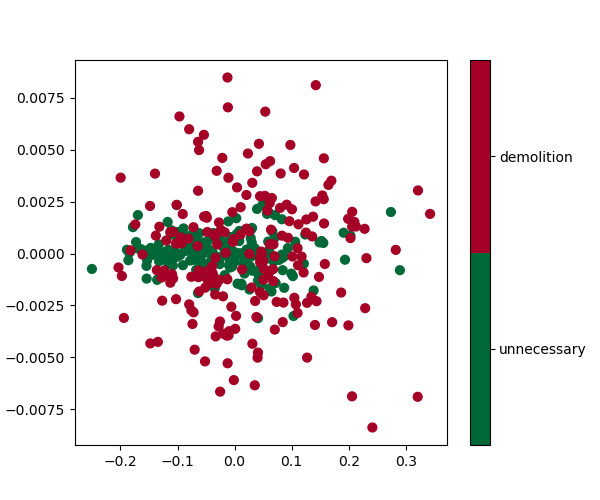

In [13]:
fig, ax = plt.subplots(figsize=(6,5))

cmap = plt.get_cmap('RdYlGn_r', 2)

plot1 = ax.scatter(X_reduced[:,0], X_reduced[:,1], c=damage_classes, cmap=cmap, vmin=-0.5, vmax=1.5, s=40)
cax = plt.colorbar(plot1, ticks=list(mapping.values()))
cax.ax.set_yticklabels(mapping.keys())
plt.show()

To visualize what is happening, we are constraining the final hidden layer of the neural network to only have two neurons, allowing us to visualize it.

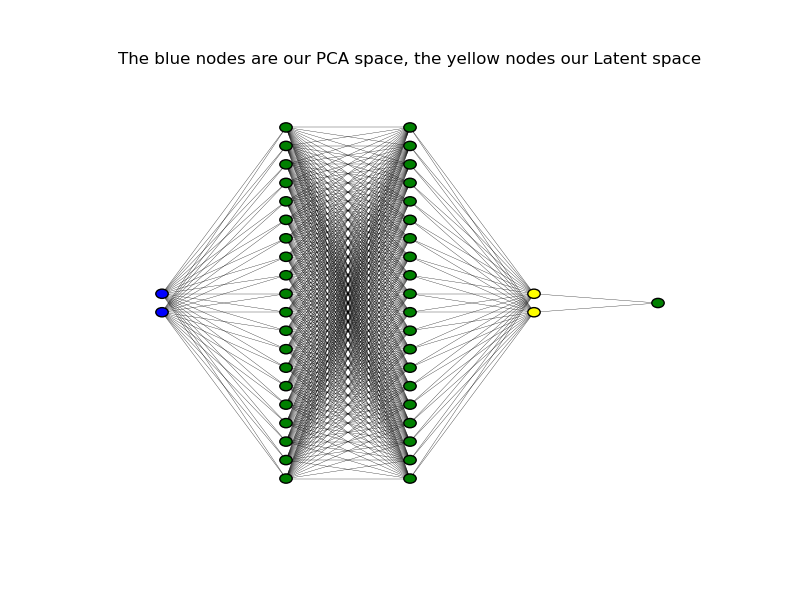

In [14]:
fig, ax = plt.subplots(figsize=(8,6))
draw_neural_net(ax, .1, .9, .1, .9, [2, 20, 20, 2, 1])
ax.set_title('The blue nodes are our PCA space, the yellow nodes our Latent space')
ax.axis('off')
plt.show()

In [15]:
# Normalize data
xscaler = StandardScaler()
# xit = xscaler.inverse_transform
X_reduced = xscaler.fit_transform(X_reduced)

# Split into train, validation & test data
X_train, X_test, y_train, y_test, ind_train, ind_test = train_test_split(X_reduced, damage_classes, indices, train_size=0.7)
X_val, X_test, y_val, y_test, ind_val, ind_test = train_test_split(X_test, y_test, ind_test, train_size=0.5)

# Set up NN
NN = manualMLPClassifier(solver='adam', hidden_layer_sizes=(20, 20, 2), activation='relu', random_state=1)

# Initialize arrays to store data while training
epochs = 3000
latent_states_train = np.zeros((epochs, len(X_train), 2))
latent_states_val = np.zeros((epochs, len(X_val), 2))

# Grid PCA space
dx_points = 20
x = np.linspace(-4, 4, dx_points)
y = np.linspace(-4, 4, dx_points)
xv, yv = np.meshgrid(x, y, indexing='xy')
xv_l = xv.reshape(-1, 1)
yv_l = yv.reshape(-1, 1)
PCA_points = np.append(xv_l, yv_l, axis=1)

PCA_state_out = np.zeros((epochs, dx_points*dx_points))  # Store outcomes

# Grid latent space
grid_dx_points = 40
x = np.linspace(0, 1, grid_dx_points)
y = np.linspace(0, 1, grid_dx_points)
xvl, yvl = np.meshgrid(x, y, indexing='xy')
xvl_l = xvl.reshape(-1, 1)
yvl_l = yvl.reshape(-1, 1)
latent_grid_points = np.append(xvl_l, yvl_l, axis=1)

latent_state_out = np.empty((epochs, grid_dx_points*grid_dx_points))          # Store latent outcomes
latent_grid_deformed = np.empty((epochs, grid_dx_points * grid_dx_points, 2))  # Store latent positions

# train NN
NN, training_score, validation_score = NN_train_visualize(NN, X_train, y_train, X_val, y_val, classes=unique_classes, epochs=epochs, latent_states_train=latent_states_train, latent_states_val=latent_states_val, latent_state_out=latent_state_out, latent_grid_points=latent_grid_points, PCA_state_out=PCA_state_out, PCA_grid_points=PCA_points, transformed_latent_grid=latent_grid_deformed)

# Compute train and test accuracy
print(f"Train accuracy: {NN.score(X_train, y_train)}")
print(f"Validation accuracy: {NN.score(X_val, y_val)}")
print(f"Test accuracy: {NN.score(X_test, y_test)}")

Iteration 0 out of 3000
Iteration 200 out of 3000
Iteration 400 out of 3000
Iteration 600 out of 3000
Iteration 800 out of 3000
Iteration 1000 out of 3000
Iteration 1200 out of 3000
Iteration 1400 out of 3000
Iteration 1600 out of 3000
Iteration 1800 out of 3000
Iteration 2000 out of 3000
Iteration 2200 out of 3000
Iteration 2400 out of 3000
Iteration 2600 out of 3000
Iteration 2800 out of 3000
Reachead max_epochs ( 3000 )
Train accuracy: 0.8571428571428571
Validation accuracy: 0.8
Test accuracy: 0.7166666666666667


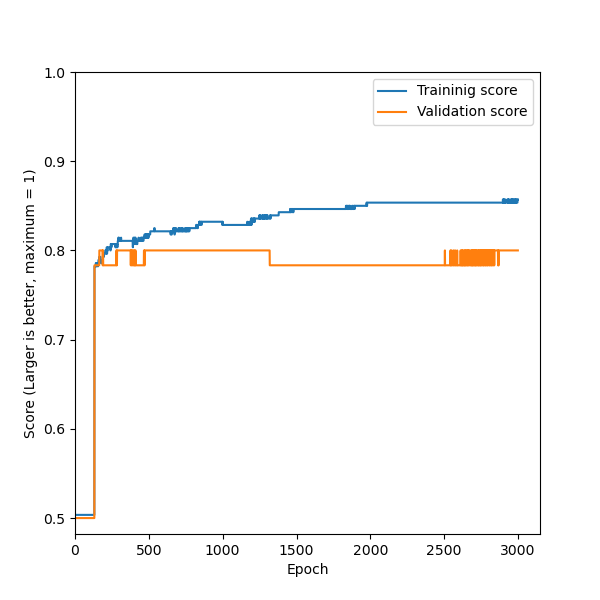

In [16]:
fig, ax = plt.subplots(figsize=(6,6))
plt.plot(training_score, label='Traininig score')
plt.plot(validation_score, label='Validation score')
plt.xlim(xmin=0)
plt.ylim(ymax=1)
plt.xlabel('Epoch')
plt.ylabel('Score (Larger is better, maximum = 1)')
plt.legend()
plt.show()

Now we will interactively plot the complete training procedure of how the network makes its predictions. We show both the original PCA space, as well as the changing latent space (the final NN hidden layer). Note that after the final hidden layer, the output prediction is linear, as no more activation functions are used. This shows how this network creates a nonlinear mapping to a latent space in which a linear decision boundary can be drawn that defines a non-linear decision boundary in the original space.

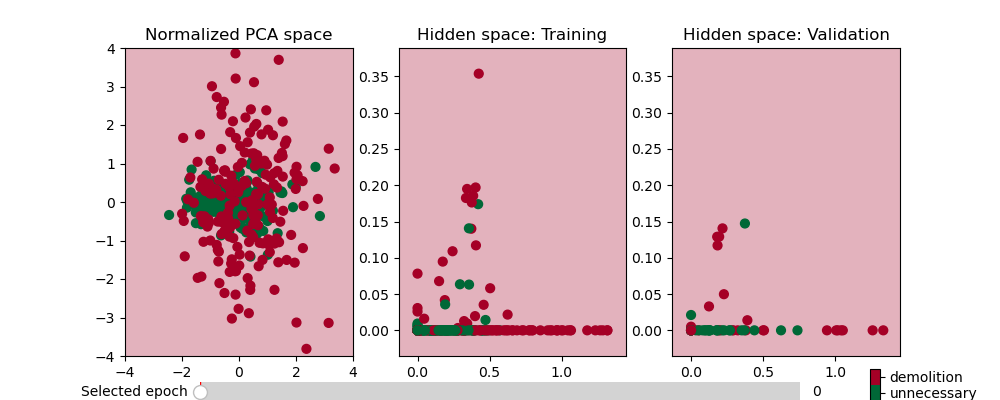

In [17]:
cur_sel_epoch = 0
fig, axs = plt.subplots(1, 3, figsize=(10,4))

# reshape deformed latent grid to correct format
latent_grid_deformed = latent_grid_deformed.reshape(epochs, grid_dx_points, grid_dx_points, 2)

# Background Contour plot
axs[0].contourf(xv, yv, PCA_state_out[cur_sel_epoch].reshape(xv.shape), [0, 0.5, 1], cmap=cmap, alpha=0.3)
axs[1].contourf(latent_grid_deformed[cur_sel_epoch,:,:,0], latent_grid_deformed[cur_sel_epoch,:,:,1], latent_state_out[cur_sel_epoch].reshape(xvl.shape), [0, 0.5, 1], cmap=cmap, alpha=0.3)
axs[2].contourf(latent_grid_deformed[cur_sel_epoch,:,:,0], latent_grid_deformed[cur_sel_epoch,:,:,1], latent_state_out[cur_sel_epoch].reshape(xvl.shape), [0, 0.5, 1], cmap=cmap, alpha=0.3)

# Foreground datapoints
# prediction_color = cmap(tmp_out_forward/2)
plot_dynamic1 = axs[0].scatter(X_reduced[:,0], X_reduced[:,1], c=damage_classes, cmap=cmap, vmin=-0.5, vmax=1.5, s=40) # PCA
plot_dynamic2 = axs[1].scatter(latent_states_train[cur_sel_epoch,:,0], latent_states_train[cur_sel_epoch,:,1], c=y_train, cmap=cmap, vmin=-0.5, vmax=1.5, s=40, linewidth=1) # Hidden: Train
plot_dynamic3 = axs[2].scatter(latent_states_val[cur_sel_epoch,:,0], latent_states_val[cur_sel_epoch,:,1], c=y_val, cmap=cmap, vmin=-0.5, vmax=1.5, s=40, linewidth=1) # Hidden: Validate
axs[0].set_title('Normalized PCA space')
axs[1].set_title('Hidden space: Training')
axs[2].set_title('Hidden space: Validation')

# Add slider
axepochs = plt.axes([0.2, -0.03, 0.6, 0.1])
epoch_slider = Slider(ax=axepochs, label='Selected epoch', valmin=0, valmax=epochs)

def update(val):
    val = int(val)

    # Re-draw Plot 0
    axs[0].clear()
    axs[0].contourf(xv, yv, PCA_state_out[val].reshape(xv.shape), [0, 0.5, 1], cmap=cmap, alpha=0.3)
    axs[0].scatter(X_reduced[:,0], X_reduced[:,1], c=damage_classes, cmap=cmap, vmin=-0.5, vmax=1.5, s=40) # PCA
    axs[0].set_title('Normalized PCA space')

    # Re-draw Plot 1
    axs[1].clear()
    axs[1].contourf(latent_grid_deformed[val,:,:,0], latent_grid_deformed[val,:,:,1], latent_state_out[val].reshape(xvl.shape), [0, 0.5, 1], cmap=cmap, alpha=0.3)
    axs[1].scatter(latent_states_train[val,:,0], latent_states_train[val,:,1], c=y_train, cmap=cmap, vmin=-0.5, vmax=1.5, s=40, linewidth=1) # Hidden: Train
    axs[1].set_title('Latent space: Training samples')

    # Re-draw Plot 2
    axs[2].clear()
    axs[2].contourf(latent_grid_deformed[val,:,:,0], latent_grid_deformed[val,:,:,1], latent_state_out[val].reshape(xvl.shape), [0, 0.5, 1], cmap=cmap, alpha=0.3)
    axs[2].scatter(latent_states_val[val,:,0], latent_states_val[val,:,1], c=y_val, cmap=cmap, vmin=-0.5, vmax=1.5, s=40, linewidth=1) # Hidden: Validate
    axs[2].set_title('Latent space: Validation samples')

    fig.canvas.draw_idle()

epoch_slider.on_changed(update)


cax = plt.axes([0.87, -0.002, 0.01, 0.08])
plt.colorbar(plot_dynamic2, cax=cax, ticks=list(mapping.values()))
cax.set_yticklabels(mapping.keys())

plt.show()

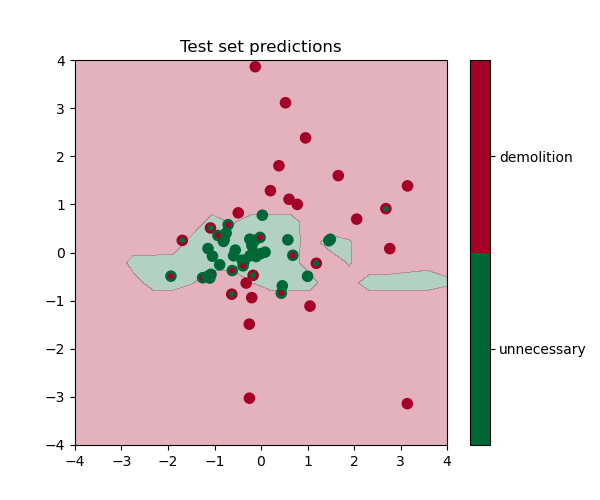

In [18]:
fig, ax = plt.subplots(figsize=(6,5))
pred = NN.predict(X_test)
prediction_color = cmap(pred/2)

ax.contourf(xv, yv, PCA_state_out[-1].reshape(xv.shape), [0, 0.5, 1], cmap=cmap, alpha=0.3)

plot1 = ax.scatter(X_test[:,0], X_test[:,1], c=y_test, edgecolors=prediction_color, cmap=cmap, vmin=-0.5, vmax=1.5, s=40, linewidth=2)
cax = plt.colorbar(plot1, ticks=list(mapping.values()))
ax.set_title('Test set predictions')
cax.ax.set_yticklabels(mapping.keys())
plt.show()

**Exercise 2:** use the slider above to understand what is happening inside the classification network. What happens when you for example select a different activation function?


Now that we have seen how PCA and the classifier work, let us use both to do some analysis. **Excercise 3:** figure out if only using the second and third PCA mode leads to a more accurate prediction than only using the first and second mode, using the same network architecture.

In [19]:
# ------------------
# Your code here
# ------------------
num_modes = 3
pca = PCA(n_components=num_modes)
pca.fit(X)
print( f"The variance explained by each component = {pca.explained_variance_ratio_}")
print( f"The singular values = {pca.singular_values_}")
X_reduced = pca.transform(X)
X_reduced = X_reduced[:,1:]     # Only select 2nd and 3rd eigenvalue

# Normalize
xscaler = StandardScaler()
X_reduced = xscaler.fit_transform(X_reduced)

# Split into train, validation & test data
X_train, X_test, y_train, y_test, ind_train, ind_test = train_test_split(X_reduced, damage_classes, indices, train_size=0.7)
X_val, X_test, y_val, y_test, ind_val, ind_test = train_test_split(X_test, y_test, ind_test, train_size=0.5)


The variance explained by each component = [9.97778486e-01 4.62766282e-04 1.66749000e-04]
The singular values = [2.03912554 0.04391448 0.0263608 ]


Iteration 0 out of 1000
Iteration 200 out of 1000
Iteration 400 out of 1000
Iteration 600 out of 1000
Iteration 800 out of 1000
Final train accuracy: 0.8785714285714286
Final validation accuracy: 0.9166666666666666
Final test accuracy: 0.8166666666666667


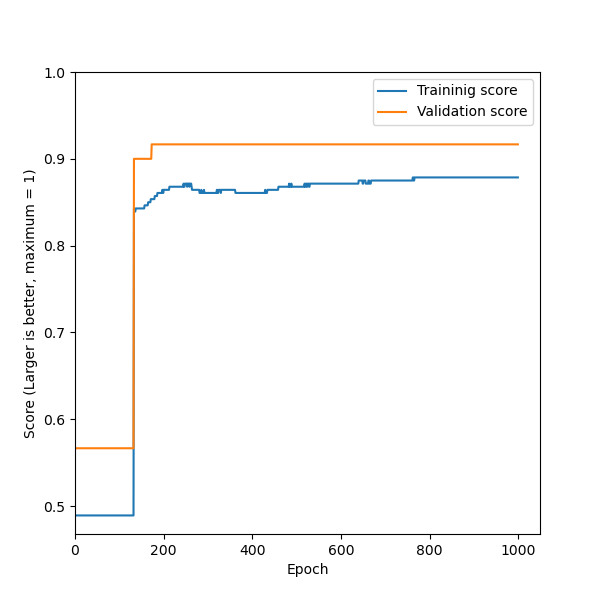

In [20]:
# NN = MLPClassifier(solver='adam', hidden_layer_sizes=(20, 20, 2), activation='relu', random_state=1, alpha=0.35)
NN = manualMLPClassifier(solver='adam', hidden_layer_sizes=(20, 20, 2), activation='relu', random_state=1)
NN, training_score, validation_score = NN_train(NN, X_train, y_train, X_val, y_val, epochs=1000)

# Print final scores
print(f"Final train accuracy: {NN.score(X_train, y_train)}")
print(f"Final validation accuracy: {NN.score(X_val, y_val)}")
print(f"Final test accuracy: {NN.score(X_test, y_test)}")

fig, ax = plt.subplots(figsize=(6,6))
plt.plot(training_score, label='Traininig score')
plt.plot(validation_score, label='Validation score')
plt.xlim(xmin=0)
plt.ylim(ymax=1)
plt.xlabel('Epoch')
plt.ylabel('Score (Larger is better, maximum = 1)')
plt.legend()
plt.show()

**Excercise 4:** use any number of features to try to train the most accurate classification model. Reflect about the implications of choosing more or less features on model selection.

The variance explained by each component = [9.97778486e-01 4.62766282e-04 1.66749000e-04 5.10796726e-05
 2.38616399e-05 1.37532133e-05 1.19286000e-05 1.14263044e-05
 1.12356120e-05 1.11659744e-05 1.09309409e-05 1.07481188e-05
 1.04447305e-05 1.03874633e-05 1.02895634e-05 1.01309301e-05
 1.00176672e-05 9.93830024e-06 9.87880019e-06 9.71848599e-06
 9.70136383e-06 9.58590520e-06 9.48181190e-06 9.40331933e-06
 9.31192123e-06]
The singular values = [2.03912554 0.04391448 0.0263608  0.01458985 0.00997188 0.00757058
 0.00705053 0.00690049 0.00684266 0.00682143 0.00674925 0.00669257
 0.00659744 0.00657933 0.00654825 0.00649758 0.00646116 0.00643551
 0.00641622 0.00636394 0.00635833 0.00632038 0.00628597 0.0062599
 0.0062294 ]


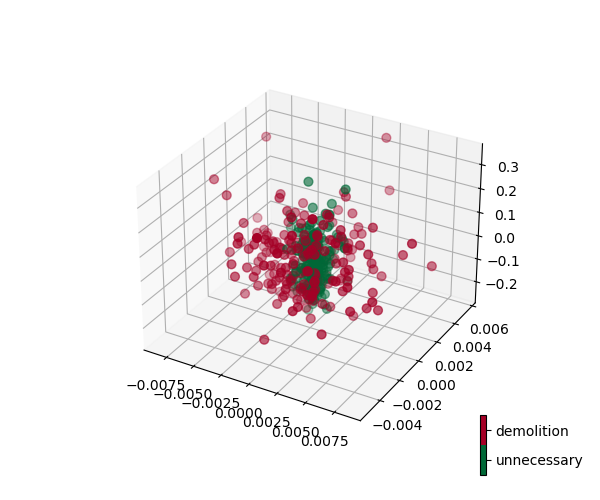

In [21]:
# ------------------
# Your code here
# ------------------

# -------------------
num_modes = 25  #<- Change this value to include more or less modes
# -------------------

pca = PCA(n_components=num_modes)
pca.fit(X)
print( f"The variance explained by each component = {pca.explained_variance_ratio_}")
print( f"The singular values = {pca.singular_values_}")
X_reduced = pca.transform(X)

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(projection='3d')

cmap = plt.get_cmap('RdYlGn_r', 2)

ax.scatter(X_reduced[:,1], X_reduced[:,2], X_reduced[:,0], c=damage_classes, cmap=cmap, vmin=-0.5, vmax=1.5, s=40)

cax = plt.axes([0.8, .05, 0.01, 0.12])
plt.colorbar(plot1, cax=cax, ticks=list(mapping.values()))
cax.set_yticklabels(mapping.keys())

plt.show()

In [22]:
# Normalize
xscaler = StandardScaler()
X_reduced = xscaler.fit_transform(X_reduced)

# Split into train, validation & test data
X_train, X_test, y_train, y_test, ind_train, ind_test = train_test_split(X_reduced, damage_classes, indices, train_size=0.7)
X_val, X_test, y_val, y_test, ind_val, ind_test = train_test_split(X_test, y_test, ind_test, train_size=0.5)

In [23]:
NN = MLPClassifier(solver='adam', hidden_layer_sizes=(40, 40), activation='relu', random_state=1, alpha=2)
NN, training_score, validation_score = NN_train(NN, X_train, y_train, X_val, y_val, epochs=1000)

# Print final scores
print(f"Final train accuracy: {NN.score(X_train, y_train)}")
print(f"Final validation accuracy: {NN.score(X_val, y_val)}")
print(f"Final test accuracy: {NN.score(X_test, y_test)}")


Iteration 0 out of 1000
Iteration 200 out of 1000
Iteration 400 out of 1000
Iteration 600 out of 1000
Iteration 800 out of 1000
Final train accuracy: 0.9964285714285714
Final validation accuracy: 0.8833333333333333
Final test accuracy: 0.9333333333333333


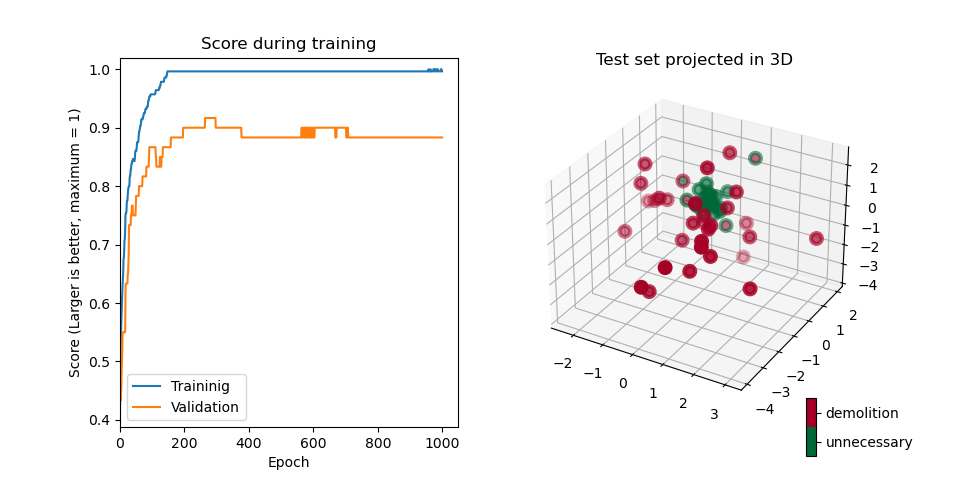

In [24]:
pred = NN.predict(X_test)

# Plot score and test prediction
fig = plt.figure(figsize=plt.figaspect(.5))
ax = fig.add_subplot(1,2,1)
ax.plot(training_score, label='Traininig')
ax.plot(validation_score, label='Validation')
ax.set_title('Score during training')
ax.set_xlim(xmin=0)
ax.set_ylim(ymax=1.02)
ax.set_xlabel('Epoch')
ax.set_ylabel('Score (Larger is better, maximum = 1)')
ax.legend()

ax2 = fig.add_subplot(1,2,2,projection='3d')
prediction_color = cmap(pred/2)
plot1 = ax2.scatter(X_test[:,1], X_test[:,2], X_test[:,3], c=y_test, cmap=cmap, edgecolors=prediction_color, vmin=-0.5, vmax=1.5, s=60, linewidth=3)
ax2.set_title('Test set projected in 3D')

cax = plt.axes([0.84, 0.05, 0.01, 0.12])
plt.colorbar(plot1, cax=cax, ticks=list(mapping.values()))
cax.set_yticklabels(mapping.keys())

plt.show()

Compare this result to the accuracy you obtained using 2 sensors. You will likely observe that using all data with dimensionality reduction provided a better score.

## Conclusion
In this notebook, we looked at predicting classes instead of continuous values. First, looking at model selection for classification, the aim was to find the best model using the data from two specific sensors. Following this, we looked at what happens inside a classification neural network. Finally, by selecting using several modes of PCA, the highest classification score was obtained.